In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as px

import sklearn as sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import precision_score, f1_score, recall_score

In [89]:
# Load processed data features
data_features = pd.read_csv('processed_data/data_features.csv', header=[0,1], index_col=0, parse_dates=True)
# Forward fill missing values
data_features = data_features.ffill()

# Quick look at the data
print('features :' + str(data_features.keys().get_level_values(1).unique()))
data_features.head()

features :Index(['Stochastic', 'William', 'Basic_Mid', 'Close_to_High', 'Close_to_Low',
       'DD_Return', 'Close_MA_5', 'Close_STD_5', 'Close_GROWTH_5',
       'Close_MA_10', 'Close_STD_10', 'Close_GROWTH_10', 'Close_MA_15',
       'Close_STD_15', 'Close_GROWTH_15', 'Close_MA_35', 'Close_STD_35',
       'Close_GROWTH_35', 'Close_MA_40', 'Close_STD_40', 'Close_GROWTH_40',
       'Close_MA_45', 'Close_STD_45', 'Close_GROWTH_45', 'High_MA_5',
       'High_STD_5', 'High_GROWTH_5', 'High_MA_10', 'High_STD_10',
       'High_GROWTH_10', 'High_MA_15', 'High_STD_15', 'High_GROWTH_15',
       'High_MA_35', 'High_STD_35', 'High_GROWTH_35', 'High_MA_40',
       'High_STD_40', 'High_GROWTH_40', 'High_MA_45', 'High_STD_45',
       'High_GROWTH_45', 'Low_MA_5', 'Low_STD_5', 'Low_GROWTH_5', 'Low_MA_10',
       'Low_STD_10', 'Low_GROWTH_10', 'Low_MA_15', 'Low_STD_15',
       'Low_GROWTH_15', 'Low_MA_35', 'Low_STD_35', 'Low_GROWTH_35',
       'Low_MA_40', 'Low_STD_40', 'Low_GROWTH_40', 'Low_MA_45', 'L

CDE                                                  \
           Stochastic   William  Basic_Mid Close_to_High Close_to_Low   
Date                                                                    
2005-01-03   0.090908  0.909092  38.100000      0.026455    -0.002645   
2005-01-04   0.142857  0.857143  36.600000      0.049862    -0.008310   
2005-01-05   0.125001  0.874999  36.300001      0.038997    -0.005571   
2005-01-06   0.210527  0.789473  35.366666      0.042857    -0.011429   
2005-01-07   0.499998  0.500002  35.300001      0.016997    -0.016997   

                                                                        ...  \
           DD_Return Close_MA_5 Close_STD_5 Close_GROWTH_5 Close_MA_10  ...   
Date                                                                    ...   
2005-01-03       NaN        NaN         NaN            NaN         NaN  ...   
2005-01-04 -0.044974        NaN         NaN            NaN         NaN  ...   
2005-01-05 -0.005540        NaN         NaN            NaN         NaN  ...   
2005-01-06 -0.025070        NaN         NaN            NaN         NaN  ...   
2005-01-07  0.008571   1.020397    0.030247            NaN         NaN  ...   

                    LRCX                                          \
           Low_TREND_150 Low_STD_150 Low_GROWTH_150 Close_CORR_5   
Date                                                               
2005-01-03           NaN         NaN            NaN          NaN   
2005-01-04           NaN         NaN            NaN          NaN   
2005-01-05           NaN         NaN            NaN          NaN   
2005-01-06           NaN         NaN            NaN          NaN   
2005-01-07           NaN         NaN            NaN          NaN   

                                                                    \
           Close_CORR_10 Close_CORR_15 Close_CORR_35 Close_CORR_40   
Date                                                                 
2005-01-03           NaN           NaN           NaN           NaN   
2005-01-04           NaN           NaN           NaN           NaN   
2005-01-05           NaN           NaN           NaN           NaN   
2005-01-06           NaN           NaN           NaN           NaN   
2005-01-07           NaN           NaN           NaN           NaN   

                                 
           Close_CORR_45 Signal  
Date                             
2005-01-03           NaN      0  
2005-01-04           NaN     -1  
2005-01-05           NaN     -1  
2005-01-06           NaN     -1  
2005-01-07           NaN      0  

[5 rows x 12972 columns]

In [90]:
# Filter data_features to include only rows after the date N due to feature availability
N = 151
filtered_data = data_features[data_features.index > data_features.index[N]]
first_date = filtered_data.index.min()
last_date = filtered_data.index.max()
print(f'Data filtered to include only rows after {first_date}')
print(f"Data filtered to include only rows before {last_date}")

Data filtered to include only rows after 2005-08-10 00:00:00
Data filtered to include only rows before 2025-09-29 00:00:00


In [91]:
# Fit model and parameters for each period and ticker

duration_period = 0.5 # % year
window_size = int(252* duration_period)
trigger_up_grid = np.linspace(0.01, 0.99, 10)
trigger_down_grid = np.linspace(-0.01, -0.99, 10)

filtered_data = filtered_data.ffill()
Tickers = filtered_data.columns.get_level_values(0).unique()

tscv = TimeSeriesSplit(n_splits=20, max_train_size=window_size)

metrics_perf = []
current_step = 0
total_steps = tscv.get_n_splits(filtered_data)
for train_index, test_index in tscv.split(filtered_data):
    print(f'Processing fold {current_step + 1} of {total_steps}')
    current_step += 1
    train_data, test_data = filtered_data.iloc[train_index], filtered_data.iloc[test_index]
    for ticker in Tickers:
        X_train, Y_train = train_data[ticker].drop(columns=['Signal']), train_data[ticker]['Signal']
        X_test, Y_test = test_data[ticker].drop(columns=['Signal']), test_data[ticker]['Signal']

        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Fit linear regression model
        model = LinearRegression()
        model.fit(X_train_scaled, Y_train)

        # Make predictions
        Y_train_pred_src = model.predict(X_train_scaled)
        Y_test_pred_src = model.predict(X_test_scaled)

        # Find optimal triggers based on performance metrics
        best_trigger_up = None
        best_trigger_down = None
        best_return_train = -np.inf
        best_return_test = -np.inf

        for trigger_up in trigger_up_grid:
            for trigger_down in trigger_down_grid:

                # Define performance metrics (model returns based on triggers)
                Y_train_pred = np.where(Y_train_pred_src > trigger_up, 1, np.where(Y_train_pred_src < trigger_down, -1, 0))
                Y_test_pred = np.where(Y_test_pred_src > trigger_up, 1, np.where(Y_test_pred_src < trigger_down, -1, 0))
                
                # Evaluate performance
                Return = np.array(X_test.DD_Return.shift(-1).fillna(0))
                return_predicted_train = float(np.sum(Y_train_pred * X_train.DD_Return.shift(-1).fillna(0)))
                return_predicted_test = float(np.sum(Y_test_pred * Return))

                if return_predicted_train > best_return_train:
                    best_trigger_up = trigger_up
                    best_trigger_down = trigger_down
                    best_return_train = return_predicted_train
                    market_return_train = float(np.sum(X_train.DD_Return.shift(-1).fillna(0)))
                    best_return_test = return_predicted_test
                    market_return_test = float(np.sum(Return))
        
        metrics_perf.append({
            'Ticker': ticker,
            'Train Start': train_data.index.min(),
            'Train End': train_data.index.max(),
            'Test Start': test_data.index.min(),
            'Test End': test_data.index.max(),
            'Return_Predicted_Train': best_return_train,
            'Return_Predicted_Test': best_return_test,
            'Market_Return_Train': market_return_train,
            'Market_Return_Test': market_return_test,
            'Ratio_Train': best_return_train / market_return_train if market_return_train != 0 else 0,
            'Model_train_>_Market_train': 1 if best_return_train > market_return_train else 0,
            'Model_test_>_Market_test': 1 if best_return_test > market_return_test else 0,
            'Trigger_Up': best_trigger_up,
            'Trigger_Down': best_trigger_down,
        })

metrics_perf_df = pd.DataFrame(metrics_perf)
metrics_perf_df.to_csv('model/linear/metrics_raw_data.csv', index=False)
metrics_perf_df

Processing fold 1 of 20
Processing fold 2 of 20
Processing fold 3 of 20
Processing fold 4 of 20
Processing fold 5 of 20
Processing fold 6 of 20
Processing fold 7 of 20
Processing fold 8 of 20
Processing fold 9 of 20
Processing fold 10 of 20
Processing fold 11 of 20
Processing fold 12 of 20
Processing fold 13 of 20
Processing fold 14 of 20
Processing fold 15 of 20
Processing fold 16 of 20
Processing fold 17 of 20
Processing fold 18 of 20
Processing fold 19 of 20
Processing fold 20 of 20


,Ticker,Train Start,Train End,Test Start,Test End,Return_Predicted_Train,Return_Predicted_Test,Market_Return_Train,Market_Return_Test,Ratio_Train,Model_train_>_Market_train,Model_test_>_Market_test,Trigger_Up,Trigger_Down
0,CDE,2006-02-01,2006-08-01,2006-08-02,2007-07-18,0.545586,0.106830,0.032827,-0.167554,16.619860,1,1,0.445556,-0.772222
1,ORCL,2006-02-01,2006-08-01,2006-08-02,2007-07-18,0.116120,0.262325,0.168642,0.350804,0.688558,0,0,0.227778,-0.990000
2,AMZN,2006-02-01,2006-08-01,2006-08-02,2007-07-18,0.489380,0.107316,-0.459052,1.120364,-1.066067,1,0,0.663333,-0.336667
3,ASX,2006-02-01,2006-08-01,2006-08-02,2007-07-18,0.134360,0.040807,0.023700,0.541527,5.669247,1,0,0.118889,-0.990000
4,PTEN,2006-02-01,2006-08-01,2006-08-02,2007-07-18,0.996817,-0.472194,-0.200517,-0.050269,-4.971240,1,0,0.881111,-0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755,VALE,2024-04-12,2024-10-10,2024-10-11,2025-09-29,-0.087372,-0.086786,-0.034683,0.092216,2.519127,0,0,0.990000,-0.118889
2756,TJX,2024-04-12,2024-10-10,2024-10-11,2025-09-29,0.161445,0.157639,0.191760,0.260338,0.841916,0,0,0.118889,-0.990000
2757,CRM,2024-04-12,2024-10-10,2024-10-11,2025-09-29,-0.045921,-0.011992,0.032341,-0.104395,-1.419870,0,1,0.227778,-0.336667
2758,NFLX,2024-04-12,2024-10-10,2024-10-11,2025-09-29,0.365684,-0.543753,0.177769,0.565169,2.057076,1,0,0.010000,-0.554444


In [110]:
# lets compute the average Return_Predicted_Train and Return_Predicted_Test for Train Start dates batch
summary_graph_raw = metrics_perf_df.groupby(['Train Start', 'Train End', 'Test Start', 'Test End']).agg({
    'Return_Predicted_Train': 'mean',
    'Market_Return_Train': 'mean',
    'Return_Predicted_Test': 'mean',
    'Market_Return_Test': 'mean',
})
summary_graph_raw.to_csv('model/linear/metrics_raw_summary.csv', index=True)
summary_graph_raw

,,,,Return_Predicted_Train,Market_Return_Train,Return_Predicted_Test,Market_Return_Test
Train Start,Train End,Test Start,Test End,,,,
2006-02-01,2006-08-01,2006-08-02,2007-07-18,0.179644,0.002182,0.007475,0.264457
2007-01-18,2007-07-18,2007-07-19,2008-07-01,0.094476,0.142582,-0.063457,-0.043379
2008-01-02,2008-07-01,2008-07-02,2009-06-16,0.092164,-0.025740,-0.017947,0.046589
2008-12-15,2009-06-16,2009-06-17,2010-06-01,0.133619,0.320302,0.032753,0.276549
2009-11-30,2010-06-01,2010-06-02,2011-05-13,0.145032,0.020407,-0.023040,0.245790
2010-11-12,2011-05-13,2011-05-16,2012-04-27,0.164051,0.121839,-0.010143,0.043908
2011-10-27,2012-04-27,2012-04-30,2013-04-16,0.136916,0.062412,0.028224,0.096346
2012-10-11,2013-04-16,2013-04-17,2014-03-31,0.141748,0.082805,0.032339,0.272223
2013-09-30,2014-03-31,2014-04-01,2015-03-16,0.096362,0.139224,-0.033631,0.057306


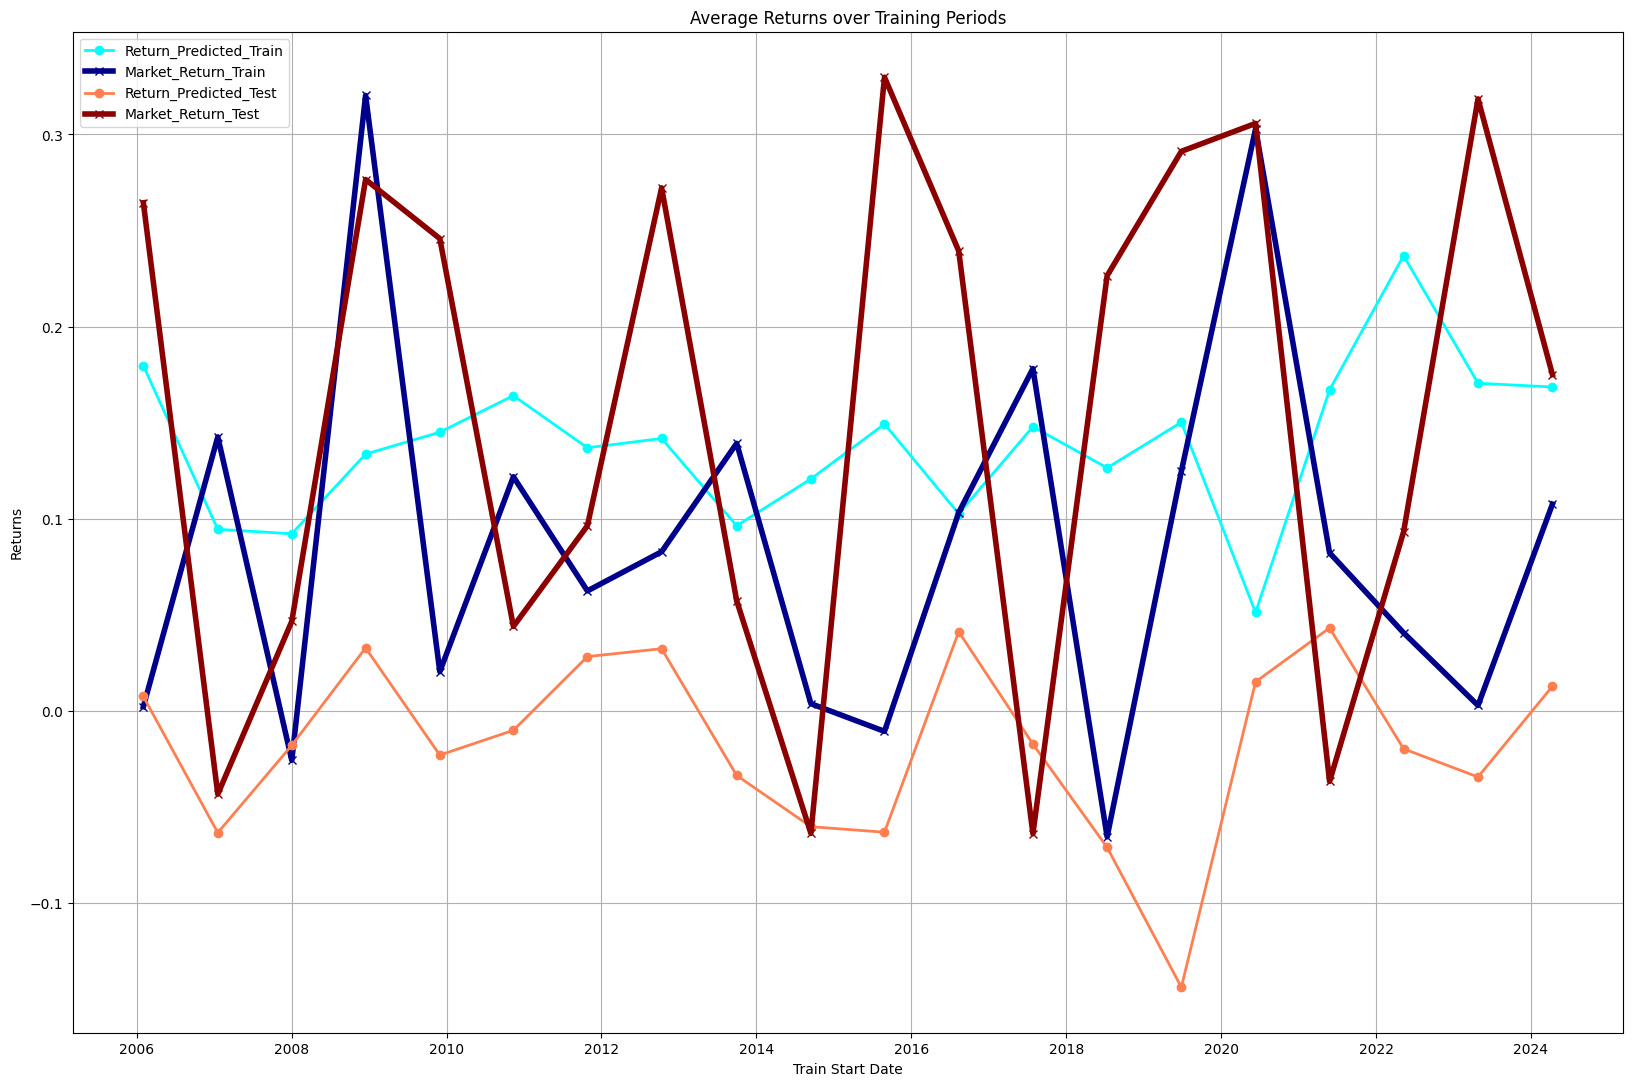

In [111]:
linewidth_market = 4
linewidth_model = 2
plt.figure(figsize=(20, 13))
plt.plot(summary_graph_raw.index.get_level_values('Train Start'), summary_graph_raw['Return_Predicted_Train'], label='Return_Predicted_Train', marker='o', linewidth=linewidth_model, color='cyan')
plt.plot(summary_graph_raw.index.get_level_values('Train Start'), summary_graph_raw['Market_Return_Train'], label='Market_Return_Train', marker='x', linewidth=linewidth_market, color='darkblue')
plt.plot(summary_graph_raw.index.get_level_values('Train Start'), summary_graph_raw['Return_Predicted_Test'], label='Return_Predicted_Test', marker='o', linewidth=linewidth_model, color='coral')
plt.plot(summary_graph_raw.index.get_level_values('Train Start'), summary_graph_raw['Market_Return_Test'], label='Market_Return_Test', marker='x', linewidth=linewidth_market, color='darkred')
plt.xlabel('Train Start Date')
plt.ylabel('Returns')
plt.title('Average Returns over Training Periods')
plt.legend()
plt.grid()
plt.show()

In [112]:
# Compute yield and std for each series from summary_graph

for serie in ['Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']:
    yields_raw = summary_graph_raw[serie].values
    mean_yield_raw = np.mean(yields_raw)
    std_yield_raw = np.std(yields_raw)
    sharpe_ratio_raw = mean_yield_raw / std_yield_raw if std_yield_raw != 0 else 0
    print(f"{serie} - Mean Yield: {mean_yield_raw:.4f}, Std Dev: {std_yield_raw:.4f}, Sharpe Ratio: {sharpe_ratio_raw:.4f}")

Return_Predicted_Train - Mean Yield: 0.1388, Std Dev: 0.0390, Sharpe Ratio: 3.5574
Market_Return_Train - Mean Yield: 0.0868, Std Dev: 0.0981, Sharpe Ratio: 0.8846
Return_Predicted_Test - Mean Yield: -0.0173, Std Dev: 0.0460, Sharpe Ratio: -0.3753
Market_Return_Test - Mean Yield: 0.1537, Std Dev: 0.1365, Sharpe Ratio: 1.1260


In [113]:
# Compute P&L evolution over time for each series
Start_dates = summary_graph_raw.index.get_level_values('Test Start')
End_dates = summary_graph_raw.index.get_level_values('Test End')

Start_End_dates = zip(Start_dates, End_dates)
# Compute P&L evolution over time for each series
PNL_data_raw = summary_graph_raw.reset_index()[['Test Start', 'Test End', 'Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']].rename(columns={'Test Start': 'Start', 'Test End': 'End'})
for start, end in Start_End_dates:
    for serie in ['Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']:
        PNL_data_raw.loc[(PNL_data_raw['Start'] == start) & (PNL_data_raw['End'] == end), serie] = summary_graph_raw.loc[(summary_graph_raw.index.get_level_values('Test Start') == start) & (summary_graph_raw.index.get_level_values('Test End') == end), serie].values[0]

for serie in ['Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']:
    PNL_data_raw[serie] = np.exp(PNL_data_raw[serie])
    PNL_data_raw[serie] = PNL_data_raw[serie].cumprod()

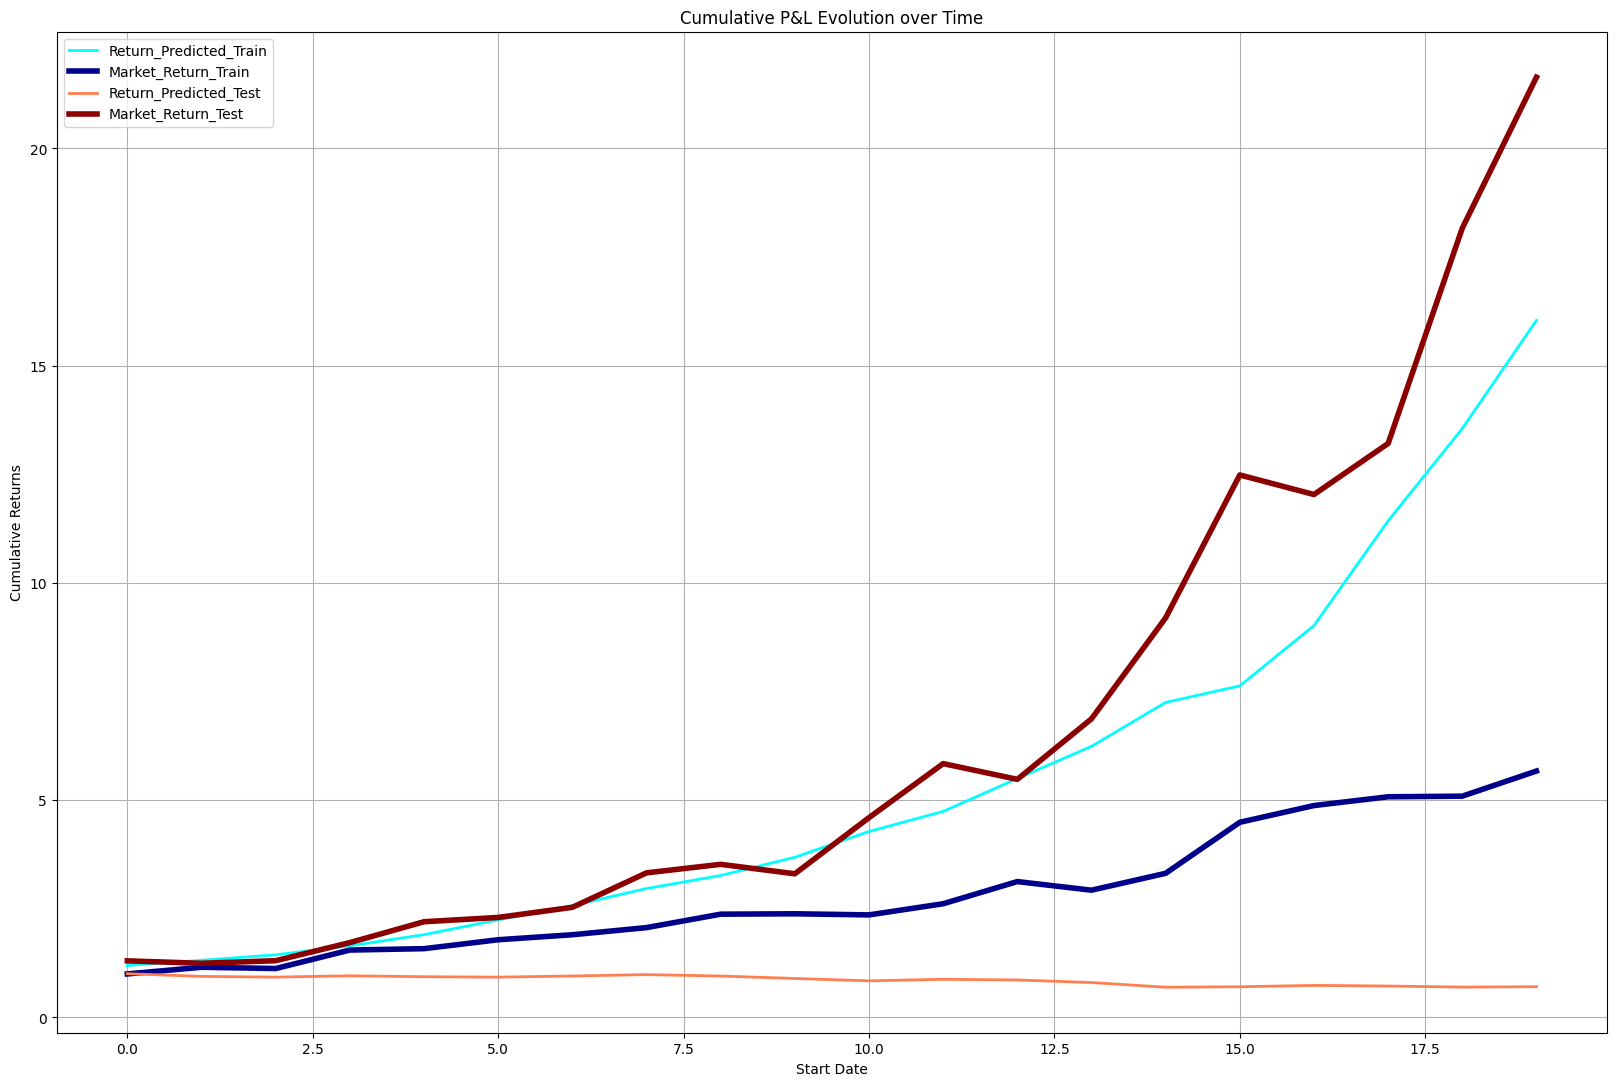

,Start,End,Return_Predicted_Train,Market_Return_Train,Return_Predicted_Test,Market_Return_Test
0,2006-08-02,2007-07-18,1.196791,1.002184,1.007503,1.302723
1,2007-07-19,2008-07-01,1.315372,1.155767,0.945556,1.247420
2,2008-07-02,2009-06-16,1.442364,1.126397,0.928737,1.306912
3,2009-06-17,2010-06-01,1.648560,1.551660,0.959659,1.723257
4,2010-06-02,2011-05-13,1.905862,1.583650,0.937802,2.203411
5,2011-05-16,2012-04-27,2.245628,1.788847,0.928337,2.302313
6,2012-04-30,2013-04-16,2.575133,1.904050,0.954912,2.535170
7,2013-04-17,2014-03-31,2.967291,2.068425,0.986297,3.328373
8,2014-04-01,2015-03-16,3.267454,2.377411,0.953679,3.524680
9,2015-03-17,2016-02-29,3.686556,2.386278,0.897850,3.306818


In [114]:
#PNL_data.set_index('Start', inplace=True)
linewidth_market = 4
linewidth_model = 2
plt.figure(figsize=(20, 13))
plt.plot(PNL_data_raw.index, PNL_data_raw['Return_Predicted_Train'], label='Return_Predicted_Train', linewidth=linewidth_model, color='cyan')
plt.plot(PNL_data_raw.index, PNL_data_raw['Market_Return_Train'], label='Market_Return_Train', linewidth=linewidth_market, color='darkblue')
plt.plot(PNL_data_raw.index, PNL_data_raw['Return_Predicted_Test'], label='Return_Predicted_Test', linewidth=linewidth_model, color='coral')
plt.plot(PNL_data_raw.index, PNL_data_raw['Market_Return_Test'], label='Market_Return_Test', linewidth=linewidth_market, color='darkred')
plt.xlabel('Start Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative P&L Evolution over Time')
plt.legend()
plt.grid()
plt.show()
PNL_data_raw

In [ ]:
Train_start_list = metrics_perf_df['Train Start'].unique().tolist()
Ticker_per_Period = {}

quantile_above = 0.75
for train_start in Train_start_list:
    quantile_n = metrics_perf_df[metrics_perf_df['Train Start'] == train_start].Ratio_Train.quantile(quantile_above)
    selected_tickers = metrics_perf_df[(metrics_perf_df['Train Start'] == train_start) &
                                       (metrics_perf_df['Ratio_Train'] >= quantile_n)]['Ticker'].tolist()
    Ticker_per_Period[train_start] = selected_tickers

print("Selected Tickers per Training Period:")
for period, tickers in Ticker_per_Period.items():
    print(f"{period}: {tickers}")

Selected Tickers per Training Period:
2006-02-01 00:00:00: ['CDE', 'ASX', 'OXY', 'NVDA', 'CAG', 'EQT', 'PBR-A', 'MDLZ', 'TXN', 'GGB', 'ABEV', 'EQNR', 'PBR', 'CTRA', 'MU', 'DVN', 'APH', 'MS', 'PFE', 'RIG', 'CSX', 'HL', 'SLB', 'NEE', 'BKR', 'CPRT', 'BP', 'ITUB', 'SHEL', 'LYG', 'LNW', 'CCJ', 'HST', 'T', 'TJX']
2007-01-18 00:00:00: ['ERIC', 'MRK', 'CAG', 'MCHP', 'EQT', 'KEY', 'TXN', 'PLUG', 'ABEV', 'NKE', 'IAG', 'F', 'MRVL', 'MU', 'WMT', 'MS', 'PCG', 'UNH', 'EXAS', 'NEE', 'CPRT', 'ABT', 'APA', 'BCS', 'TSCO', 'NEM', 'USB', 'LUV', 'WIT', 'FAST', 'ES', 'AZN', 'TGT', 'LUMN', 'TJX']
2008-01-02 00:00:00: ['ORCL', 'ERIC', 'MCHP', 'INFY', 'PLUG', 'ABEV', 'AAPL', 'PPL', 'PCG', 'B', 'HL', 'SLB', 'CMCSA', 'EXAS', 'NEE', 'CPRT', 'BP', 'ITUB', 'SHEL', 'NEM', 'USB', 'BBD', 'DIS', 'BSX', 'LNW', 'BBWI', 'FAST', 'CCJ', 'GOOG', 'TGT', 'HST', 'GOOGL', 'VALE', 'NFLX', 'LRCX']
2008-12-15 00:00:00: ['NVDA', 'EQT', 'MDT', 'GAP', 'GSK', 'GGB', 'AAPL', 'F', 'BAC', 'TU', 'TSM', 'CTRA', 'PCG', 'NOK', 'HD', 'RF', 'VL

In [94]:

tscv_selected = TimeSeriesSplit(n_splits=20, max_train_size=window_size)

metrics_perf_selected = []
current_step_selected = 0
total_steps_selected = tscv_selected.get_n_splits(filtered_data)

for train_index, test_index in tscv_selected.split(filtered_data):
    print(f'Processing fold {current_step_selected + 1} of {total_steps_selected}')
    current_step_selected += 1

    train_data, test_data = filtered_data.iloc[train_index], filtered_data.iloc[test_index]
    tickers_in_period = Ticker_per_Period.get(train_data.index.min(), [])
    for ticker in tickers_in_period:
        X_train, Y_train = train_data[ticker].drop(columns=['Signal']), train_data[ticker]['Signal']
        X_test, Y_test = test_data[ticker].drop(columns=['Signal']), test_data[ticker]['Signal']

        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Fit linear regression model
        model = LinearRegression()
        model.fit(X_train_scaled, Y_train)

        # Make predictions
        Y_train_pred_src = model.predict(X_train_scaled)
        Y_test_pred_src = model.predict(X_test_scaled)

        # Use optimal triggers based on previous model performance
        best_trigger_up = metrics_perf_df[(metrics_perf_df['Ticker'] == ticker) &
                                          (metrics_perf_df['Train Start'] == train_data.index.min())]['Trigger_Up'].values[0]
        best_trigger_down = metrics_perf_df[(metrics_perf_df['Ticker'] == ticker) &
                                            (metrics_perf_df['Train Start'] == train_data.index.min())]['Trigger_Down'].values[0]

    
        # Define performance metrics (model returns based on triggers)
        Y_train_pred = np.where(Y_train_pred_src > best_trigger_up, 1, np.where(Y_train_pred_src < best_trigger_down, -1, 0))
        Y_test_pred = np.where(Y_test_pred_src > best_trigger_up, 1, np.where(Y_test_pred_src < best_trigger_down, -1, 0))
        
        # Evaluate performance
        Return = np.array(X_test.DD_Return.shift(-1).fillna(0))

        return_predicted_train = float(np.sum(Y_train_pred * X_train.DD_Return.shift(-1).fillna(0)))
        return_predicted_test = float(np.sum(Y_test_pred * Return))

        market_return_train = float(np.sum(X_train.DD_Return.shift(-1).fillna(0)))
        market_return_test = float(np.sum(Return))

        ratio_train = return_predicted_train / market_return_train if market_return_train != 0 else 0
        ratio_test = return_predicted_test / market_return_test if market_return_test != 0 else 0    
              
        
        metrics_perf_selected.append({
            'Ticker': ticker,
            'Train Start': train_data.index.min(),
            'Train End': train_data.index.max(),
            'Test Start': test_data.index.min(),
            'Test End': test_data.index.max(),
            'Return_Predicted_Train': return_predicted_train,
            'Return_Predicted_Test': return_predicted_test,
            'Market_Return_Train': market_return_train,
            'Market_Return_Test': market_return_test,
            'Ratio_Train': ratio_train,
            'Ratio_Test': ratio_test,
            'Model_train_>_Market_train': 1 if return_predicted_train > market_return_train else 0,
            'Model_test_>_Market_test': 1 if return_predicted_test > market_return_test else 0,
            'Trigger_Up': best_trigger_up,
            'Trigger_Down': best_trigger_down,
        })

metrics_perf_selected_df = pd.DataFrame(metrics_perf_selected)
metrics_perf_selected_df.to_csv('model/linear/metrics_selected_data.csv', index=False)
metrics_perf_selected_df

Processing fold 1 of 20
Processing fold 2 of 20
Processing fold 3 of 20
Processing fold 4 of 20
Processing fold 5 of 20
Processing fold 6 of 20
Processing fold 7 of 20
Processing fold 8 of 20
Processing fold 9 of 20
Processing fold 10 of 20
Processing fold 11 of 20
Processing fold 12 of 20
Processing fold 13 of 20
Processing fold 14 of 20
Processing fold 15 of 20
Processing fold 16 of 20
Processing fold 17 of 20
Processing fold 18 of 20
Processing fold 19 of 20
Processing fold 20 of 20


,Ticker,Train Start,Train End,Test Start,Test End,Return_Predicted_Train,Return_Predicted_Test,Market_Return_Train,Market_Return_Test,Ratio_Train,Ratio_Test,Model_train_>_Market_train,Model_test_>_Market_test,Trigger_Up,Trigger_Down
0,CDE,2006-02-01,2006-08-01,2006-08-02,2007-07-18,0.545586,0.106830,0.032827,-0.167554,16.619860,-0.637588,1,1,0.445556,-0.772222
1,ASX,2006-02-01,2006-08-01,2006-08-02,2007-07-18,0.134360,0.040807,0.023700,0.541527,5.669247,0.075356,1,0,0.118889,-0.990000
2,OXY,2006-02-01,2006-08-01,2006-08-02,2007-07-18,0.400851,-0.111899,0.167939,0.191836,2.386887,-0.583303,1,0,0.881111,-0.772222
3,NVDA,2006-02-01,2006-08-01,2006-08-02,2007-07-18,0.553909,1.232244,0.004052,0.776809,136.702040,1.586291,1,1,0.118889,-0.118889
4,CAG,2006-02-01,2006-08-01,2006-08-02,2007-07-18,0.113233,0.166754,0.048394,0.238579,2.339819,0.698946,1,0,0.118889,-0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,CCJ,2024-04-12,2024-10-10,2024-10-11,2025-09-29,0.287101,0.949092,0.070428,0.610161,4.076532,1.555478,1,1,0.445556,-0.663333
696,GOOG,2024-04-12,2024-10-10,2024-10-11,2025-09-29,0.139290,0.295434,0.045031,0.449346,3.093182,0.657477,1,0,0.881111,-0.772222
697,GOOGL,2024-04-12,2024-10-10,2024-10-11,2025-09-29,0.178338,0.318169,0.047777,0.457184,3.732709,0.695933,1,0,0.990000,-0.772222
698,VALE,2024-04-12,2024-10-10,2024-10-11,2025-09-29,-0.087372,-0.086786,-0.034683,0.092216,2.519127,-0.941114,0,0,0.990000,-0.118889


In [105]:
# lets compute the average Return_Predicted_Train and Return_Predicted_Test for Train Start dates batch
summary_graph_selected = metrics_perf_selected_df.groupby(['Train Start', 'Train End', 'Test Start', 'Test End']).agg({
    'Return_Predicted_Train': 'mean',
    'Market_Return_Train': 'mean',
    'Return_Predicted_Test': 'mean',
    'Market_Return_Test': 'mean',
})
summary_graph_selected.to_csv('model/linear/metrics_selected_summary.csv', index=True)
summary_graph_selected

,,,,Return_Predicted_Train,Market_Return_Train,Return_Predicted_Test,Market_Return_Test
Train Start,Train End,Test Start,Test End,,,,
2006-02-01,2006-08-01,2006-08-02,2007-07-18,0.294344,0.075576,0.085789,0.307639
2007-01-18,2007-07-18,2007-07-19,2008-07-01,0.140477,0.078785,-0.123070,-0.154434
2008-01-02,2008-07-01,2008-07-02,2009-06-16,0.080339,-0.011518,0.016605,0.046434
2008-12-15,2009-06-16,2009-06-17,2010-06-01,0.424463,0.263971,0.039410,0.357899
2009-11-30,2010-06-01,2010-06-02,2011-05-13,0.274918,0.142315,-0.104635,0.273721
2010-11-12,2011-05-13,2011-05-16,2012-04-27,0.290606,0.118385,0.082759,0.051715
2011-10-27,2012-04-27,2012-04-30,2013-04-16,0.176807,0.066215,0.002316,0.139360
2012-10-11,2013-04-16,2013-04-17,2014-03-31,0.195534,0.104629,0.099805,0.240889
2013-09-30,2014-03-31,2014-04-01,2015-03-16,0.193958,0.088770,-0.027591,0.082297


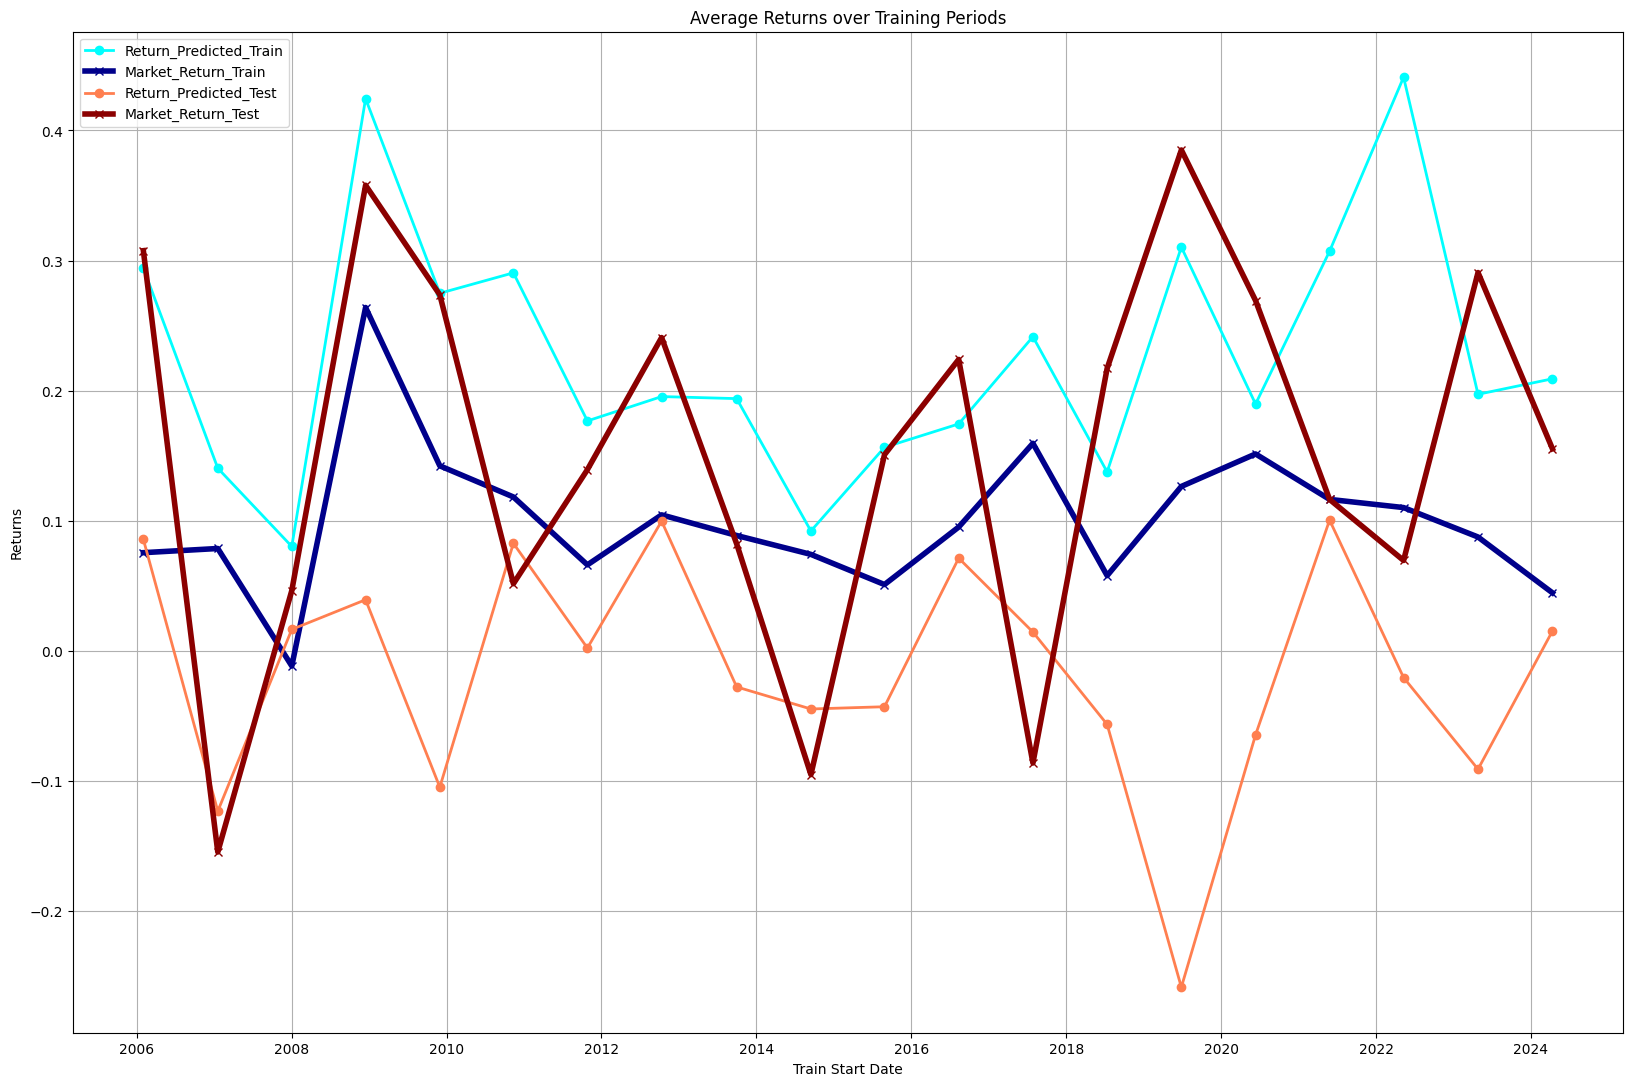

In [106]:
linewidth_market = 4
linewidth_model = 2
plt.figure(figsize=(20, 13))
plt.plot(summary_graph_selected.index.get_level_values('Train Start'), summary_graph_selected['Return_Predicted_Train'], label='Return_Predicted_Train', marker='o', linewidth=linewidth_model, color='cyan')
plt.plot(summary_graph_selected.index.get_level_values('Train Start'), summary_graph_selected['Market_Return_Train'], label='Market_Return_Train', marker='x', linewidth=linewidth_market, color='darkblue')
plt.plot(summary_graph_selected.index.get_level_values('Train Start'), summary_graph_selected['Return_Predicted_Test'], label='Return_Predicted_Test', marker='o', linewidth=linewidth_model, color='coral')
plt.plot(summary_graph_selected.index.get_level_values('Train Start'), summary_graph_selected['Market_Return_Test'], label='Market_Return_Test', marker='x', linewidth=linewidth_market, color='darkred')
plt.xlabel('Train Start Date')
plt.ylabel('Returns')
plt.title('Average Returns over Training Periods')
plt.legend()
plt.grid()
plt.show()

In [107]:
# Compute yield and std for each series from summary_graph

for serie in ['Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']:
    yields = summary_graph_selected[serie].values
    mean_yield = np.mean(yields)
    std_yield = np.std(yields)
    sharpe_ratio = mean_yield / std_yield if std_yield != 0 else 0
    print(f"{serie} - Mean Yield: {mean_yield:.4f}, Std Dev: {std_yield:.4f}, Sharpe Ratio: {sharpe_ratio:.4f}")


Return_Predicted_Train - Mean Yield: 0.2264, Std Dev: 0.0947, Sharpe Ratio: 2.3916
Market_Return_Train - Mean Yield: 0.1001, Std Dev: 0.0544, Sharpe Ratio: 1.8414
Return_Predicted_Test - Mean Yield: -0.0152, Std Dev: 0.0867, Sharpe Ratio: -0.1755
Market_Return_Test - Mean Yield: 0.1522, Std Dev: 0.1470, Sharpe Ratio: 1.0354


In [108]:
# Compute P&L evolution over time for each series
Start_dates = summary_graph_selected.index.get_level_values('Test Start')
End_dates = summary_graph_selected.index.get_level_values('Test End')

Start_End_dates = zip(Start_dates, End_dates)
# Compute P&L evolution over time for each series
PNL_data = summary_graph_selected.reset_index()[['Test Start', 'Test End', 'Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']].rename(columns={'Test Start': 'Start', 'Test End': 'End'})
for start, end in Start_End_dates:
    for serie in ['Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']:
        PNL_data.loc[(PNL_data['Start'] == start) & (PNL_data['End'] == end), serie] = summary_graph_selected.loc[(summary_graph_selected.index.get_level_values('Test Start') == start) & (summary_graph_selected.index.get_level_values('Test End') == end), serie].values[0]

for serie in ['Return_Predicted_Train', 'Market_Return_Train', 'Return_Predicted_Test', 'Market_Return_Test']:
    PNL_data[serie] = np.exp(PNL_data[serie])
    PNL_data[serie] = PNL_data[serie].cumprod()

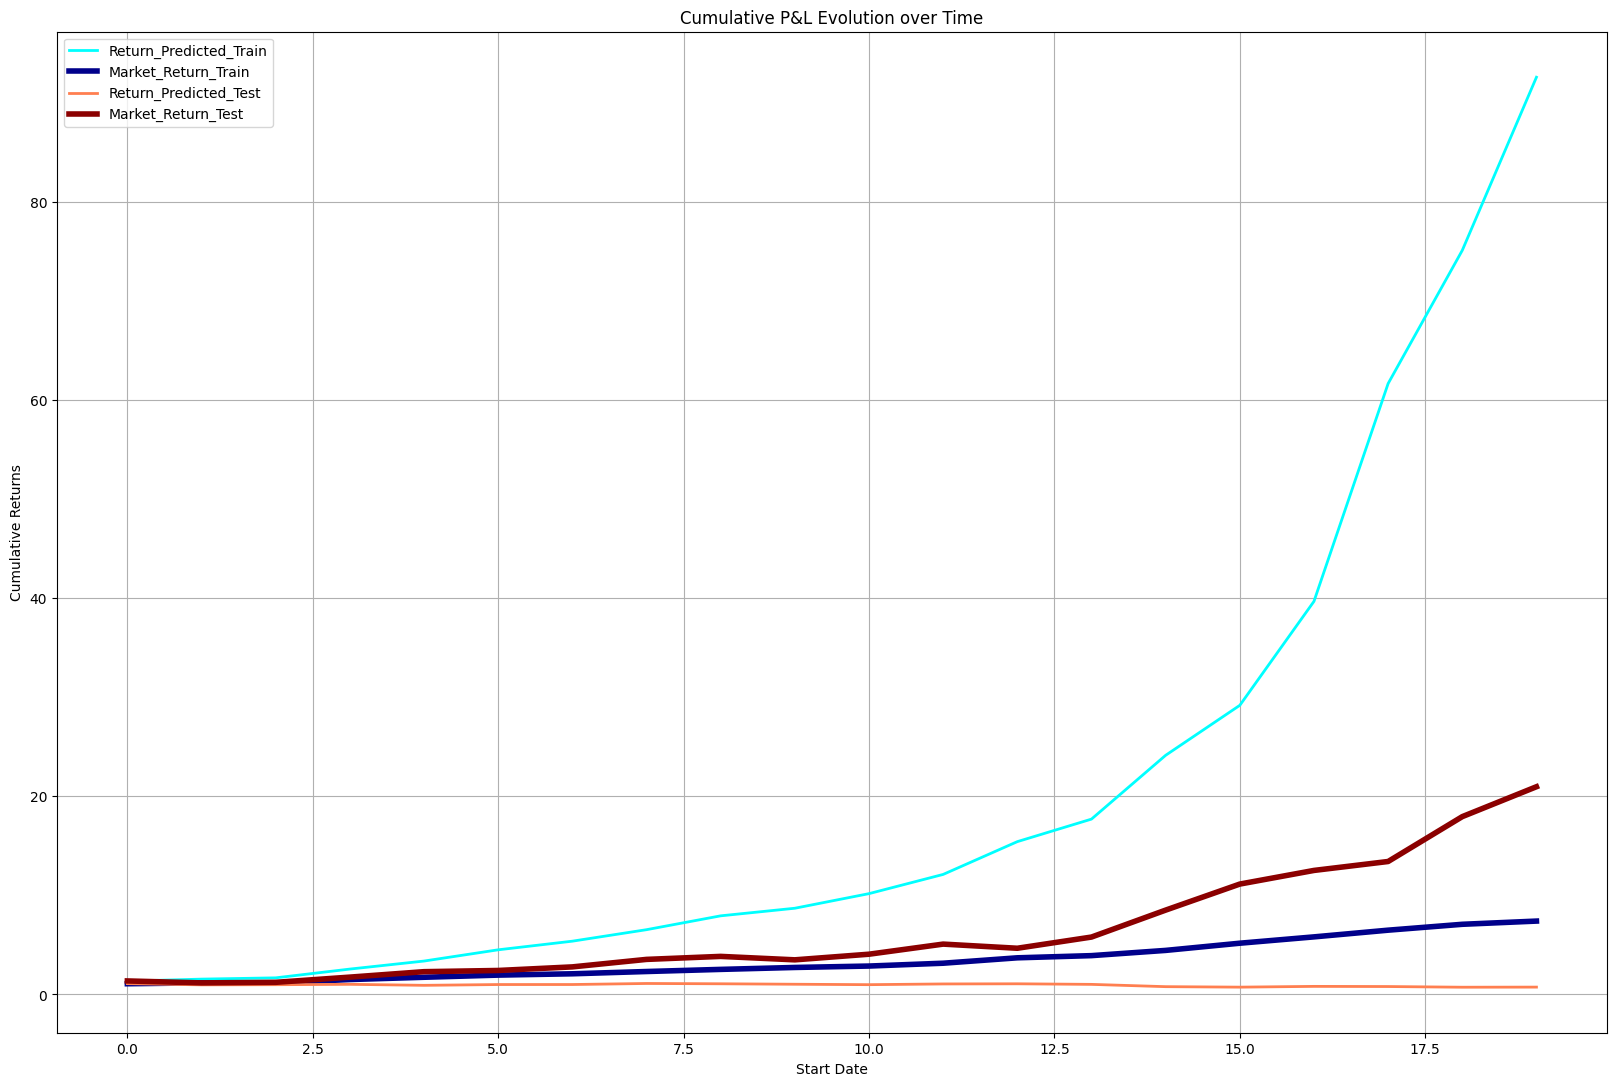

,Start,End,Return_Predicted_Train,Market_Return_Train,Return_Predicted_Test,Market_Return_Test
0,2006-08-02,2007-07-18,1.342246,1.078505,1.089577,1.360210
1,2007-07-19,2008-07-01,1.544686,1.166912,0.963406,1.165564
2,2008-07-02,2009-06-16,1.673906,1.153548,0.979536,1.220963
3,2009-06-17,2010-06-01,2.559016,1.502024,1.018910,1.746369
4,2010-06-02,2011-05-13,3.368746,1.731743,0.917685,2.296209
5,2011-05-16,2012-04-27,4.504813,1.949385,0.996863,2.418083
6,2012-04-30,2013-04-16,5.376047,2.082833,0.999174,2.779677
7,2013-04-17,2014-03-31,6.537059,2.312566,1.104043,3.536803
8,2014-04-01,2015-03-16,7.936283,2.527240,1.073997,3.840185
9,2015-03-17,2016-02-29,8.703107,2.722048,1.027206,3.492283


In [ ]:
linewidth_market = 4
linewidth_model = 2
plt.figure(figsize=(20, 13))
plt.plot(PNL_data.index, PNL_data['Return_Predicted_Train'], label='Return_Predicted_Train', linewidth=linewidth_model, color='cyan')
plt.plot(PNL_data.index, PNL_data['Market_Return_Train'], label='Market_Return_Train', linewidth=linewidth_market, color='darkblue')
plt.plot(PNL_data.index, PNL_data['Return_Predicted_Test'], label='Return_Predicted_Test', linewidth=linewidth_model, color='coral')
plt.plot(PNL_data.index, PNL_data['Market_Return_Test'], label='Market_Return_Test', linewidth=linewidth_market, color='darkred')
plt.xlabel('Start Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative P&L Evolution over Time')
plt.legend()
plt.grid()
plt.show()
PNL_data

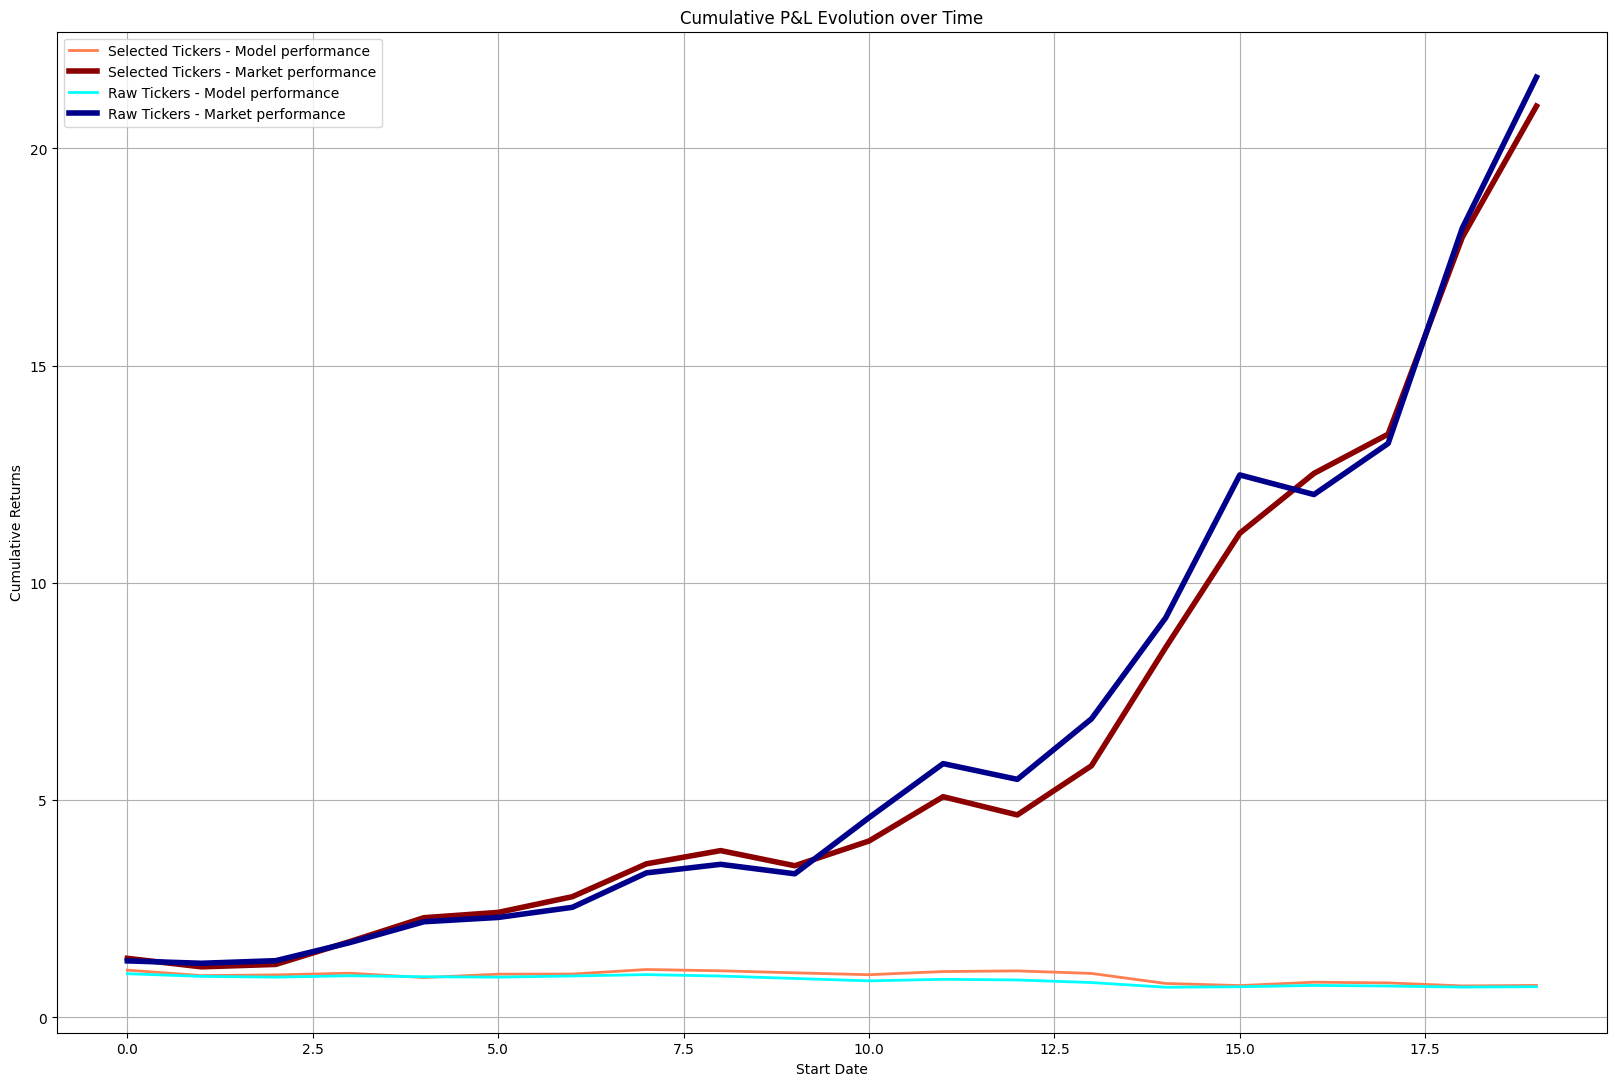

In [ ]:
# Compare PNL data between raw and selected tickers

plt.figure(figsize=(20, 13))

plt.plot(PNL_data.index, PNL_data['Return_Predicted_Test'], label='Selected Tickers - Model performance', linewidth=linewidth_model, color='coral')
#plt.plot(PNL_data.index, PNL_data['Market_Return_Test'], label='Selected Tickers - Market performance', linewidth=linewidth_market, color='darkred')

plt.plot(PNL_data_raw.index, PNL_data_raw['Return_Predicted_Test'], label='Raw Tickers - Model performance', linewidth=linewidth_model, color='cyan')
#plt.plot(PNL_data_raw.index, PNL_data_raw['Market_Return_Test'], label='Raw Tickers - Market performance', linewidth=linewidth_market, color='darkblue')

plt.xlabel('Start Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative P&L Evolution over Time')
plt.legend()
plt.grid()
plt.show()
